In [2]:
import pickle
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import numpy.typing as npt
import pandas as pd

sys.path.append("..")

from neural_rk.path import DATA_DIR, FIG_DIR, RESULT_DIR

mpl.rcParams["font.family"] = "serif"
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath, amssymb}"

# Burgers MAE

In [3]:
def read_error(
    dataset: str,
) -> tuple[list[npt.NDArray[np.float32]], list[npt.NDArray[np.float32]]]:
    from burgers.trajectory import compare_trajectory

    exp_id = dataset
    result_dir = RESULT_DIR / f"burgers_{exp_id}"
    test_id = f"{dataset}_test"

    # True values
    test_df = pd.read_pickle(DATA_DIR / f"burgers_{test_id}.pkl")
    times = [
        np.insert(np.cumsum(dts.numpy()), 0, 0.0) for dts in test_df.dts
    ]  # [num_sample, S+1]
    true_trajectories = [traj.numpy() for traj in test_df.trajectories]

    # Predicted values
    with open(result_dir / f"pred_{test_id}.pkl", "rb") as f:
        pred_trajectories = pickle.load(f)

    maes = []  # [num_sample, S]
    for true, pred in zip(true_trajectories, pred_trajectories):
        maes.append(compare_trajectory(true, pred, log=False).mean(axis=-1))

    return maes, times

def plot_mae(ax: plt.Axes, maes: list[npt.NDArray[np.float32]], times: list[npt.NDArray[np.float32]]):
    for sample_time, sample_mae in zip(times, maes):
        ax.plot(sample_time, sample_mae, color="gray", alpha=0.2)
    t = np.linspace(0.0, 1.0, len(times[0]), dtype=np.float32)
    final_mae = np.mean(maes, axis=0)
    ax.plot(t, final_mae, color="k")
    ax.set_yscale("log")
    ax.set_xlim(0.0, 1.0)
    ax.tick_params(axis="both", which="both", direction="in", labelsize=15)


maes_ic, times_ic = read_error("IC")
maes_p, times_p = read_error("P")
maes_g, times_g = read_error("G")
maes_rk, times_rk = read_error("RK")


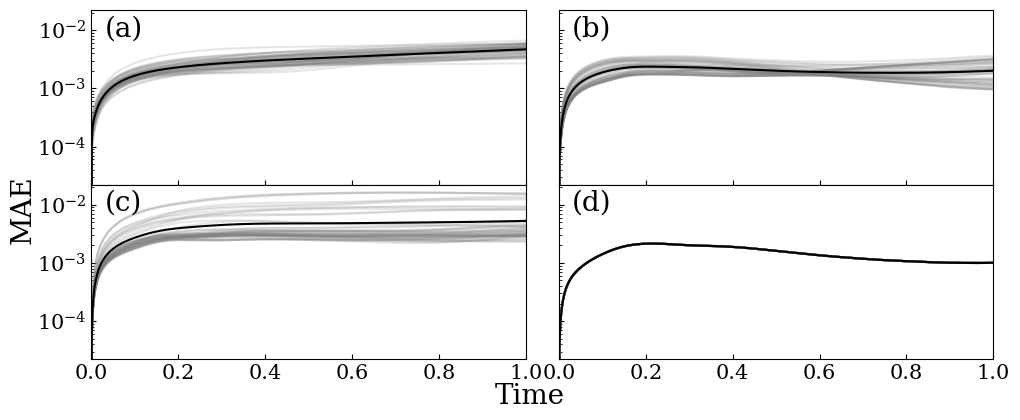

In [4]:
fig, axes = plt.subplots(figsize=(10, 4), nrows=2, ncols=2, sharex=True, sharey=True)

ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

plot_mae(ax1, maes_ic, times_ic)
plot_mae(ax2, maes_p, times_p)
plot_mae(ax3, maes_g, times_g)
plot_mae(ax4, maes_rk, times_rk)

ax1.text(0.03, 0.85, "(a)", fontsize=20, transform=ax1.transAxes)
ax2.text(0.03, 0.85, "(b)", fontsize=20, transform=ax2.transAxes)
ax3.text(0.03, 0.85, "(c)", fontsize=20, transform=ax3.transAxes)
ax4.text(0.03, 0.85, "(d)", fontsize=20, transform=ax4.transAxes)

fig.supylabel("MAE", fontsize=20, x=0.0)
fig.supxlabel("Time", fontsize=20, x=0.52, y=0.0)
fig.tight_layout(pad=0.0)

# fig.savefig(
#     f"{FIG_DIR}/burgers_mae.pdf", bbox_inches="tight", pad_inches=0.0
# )
fig.show()

# Single trajectory per equations

In [11]:
def plot_heat(gs: gridspec.SubplotSpec, sample_idx: int) -> None:
    from heat.plot import plot_image

    exp_id, test_id = "A", "A_test"
    result_dir = RESULT_DIR / f"heat_{exp_id}"
    test_df = pd.read_pickle(DATA_DIR / f"heat_{test_id}.pkl")
    true_trajectories = [traj.numpy() for traj in test_df.trajectories]
    with open(result_dir / f"pred_{test_id}.pkl", "rb") as f:
        pred_trajectories = pickle.load(f)
    true_trajectory = true_trajectories[sample_idx]
    pred_trajectory = pred_trajectories[sample_idx]
    error = true_trajectory - pred_trajectory

    nodes = set()
    # for idx in np.argsort(np.abs(error).sum(axis=0).flatten()): # minimum
    for idx in np.argsort(np.abs(error).sum(axis=0).flatten())[::-1]:  # maximum
        idx = np.unravel_index(idx, error.shape[1:])
        nodes.add(idx[0])
        if len(nodes) == 10:
            break
    nodes = np.array(list(nodes), dtype=np.int64)
    print(f"plot node with index: {nodes}")
    xticks = np.linspace(0.0, 2.0, 5)

    gs0 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs)
    ax1, ax2, ax3 = gs0.subplots()
    ax1.set_ylabel("True", fontsize=20)
    im1 = plot_image(ax1, true_trajectory, nodes, xticks=xticks)
    cbar1 = plt.colorbar(im1, ax=ax1, location="right", pad=0.01, aspect=10)
    ax1.set_xticks([])
    ax1.tick_params(axis="both", labelsize=15)
    cbar1.ax.tick_params(labelsize=15)

    ax2.set_ylabel("Prediction", fontsize=20)
    im2 = plot_image(ax2, pred_trajectory, nodes, xticks=xticks)
    cbar2 = plt.colorbar(im2, ax=ax2, location="right", pad=0.01, aspect=10)
    ax2.set_xticks([])
    ax2.tick_params(axis="both", labelsize=15)
    cbar2.ax.tick_params(labelsize=15)

    ax3.set_ylabel("Error", fontsize=20)
    im3 = plot_image(ax3, error, nodes, xticks=xticks, lim=(-0.002, 0.002))
    cbar3 = plt.colorbar(im3, ax=ax3, location="right", pad=0.01, aspect=10)
    ax3.tick_params(axis="both", labelsize=15)
    ax3.set_ylim(-0.002, 0.002)
    ax3.set_xlabel("Time", fontsize=20)
    cbar3.ax.tick_params(labelsize=15)




In [16]:
def plot_kuramoto(gs: gridspec.SubplotSpec, sample_idx: int) -> None:
    from kuramoto.plot import plot_image

    exp_id, test_id = "A", "A_test"
    result_dir = RESULT_DIR / f"kuramoto_{exp_id}"
    test_df = pd.read_pickle(DATA_DIR / f"kuramoto_{test_id}.pkl")
    true_trajectories = [traj.numpy() for traj in test_df.trajectories]
    with open(result_dir / f"pred_{test_id}.pkl", "rb") as f:
        pred_trajectories = pickle.load(f)
    true_trajcetory = true_trajectories[sample_idx]
    pred_trajectory = pred_trajectories[sample_idx]
    error = true_trajcetory - pred_trajectory

    nodes = set()
    for idx in np.argsort(np.abs(error).sum(axis=0).flatten())[::-1]:  # max
        # for idx in np.argsort(np.abs(error).sum(axis=0).flatten()):   # min
        idx = np.unravel_index(idx, error.shape[1:])
        nodes.add(idx[0])
        if len(nodes) == 10:
            break
    nodes = np.array(list(nodes), dtype=np.int64)
    xticks = np.linspace(0.0, 10.0, 5)
    print(f"plot node with index: {nodes}")

    gs0 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs)
    ax1, ax2, ax3 = gs0.subplots()
    im = plot_image(
        ax1,
        true_trajcetory,
        nodes,
        xticks=xticks,
    )
    cbar1 = plt.colorbar(
        im, ax=ax1, location="right", pad=0.01, ticks=[-np.pi, 0, np.pi], aspect=10
    )
    ax1.set_xticks([])
    cbar1.ax.set_yticklabels([r"$-\pi$", 0, r"$\pi$"], usetex=True)
    cbar1.ax.tick_params(labelsize=15)

    im = plot_image(ax2, pred_trajectory, nodes, xticks=xticks)
    cbar2 = plt.colorbar(
        im, ax=ax2, location="right", pad=0.01, ticks=[-np.pi, 0, np.pi], aspect=10
    )
    ax2.set_xticks([])
    cbar2.ax.set_yticklabels([r"$-\pi$", 0, r"$\pi$"], usetex=True)
    cbar2.ax.tick_params(labelsize=15)

    im = plot_image(ax3, error, nodes, lim=(-0.05 * np.pi, 0.05 * np.pi), xticks=xticks)
    cbar3 = plt.colorbar(
        im,
        ax=ax3,
        location="right",
        pad=0.01,
        ticks=[-0.05 * np.pi, 0, 0.05 * np.pi],
        aspect=10,
    )
    ax3.set_xlabel("Time", fontsize=20)
    ax3.tick_params(axis="x", labelsize=15)
    cbar3.ax.set_yticklabels([r"$-\pi/20$", 0, r"$\pi/20$"], usetex=True)
    cbar3.ax.tick_params(labelsize=15)

In [50]:
def plot_rossler(gs: gridspec.SubplotSpec, sample_idx: int) -> None:
    from rossler.plot import plot

    exp_id, test_id = "A", "A_test"
    result_dir = RESULT_DIR / f"rossler_{exp_id}"
    test_df = pd.read_pickle(DATA_DIR / f"rossler_{test_id}.pkl")
    true_trajectories = [traj.numpy() for traj in test_df.trajectories]
    times = np.array(
        [np.insert(np.cumsum(dts.numpy()), 0, 0.0) for dts in test_df.dts],
        dtype=np.float32,
    )
    with open(result_dir / f"pred_{test_id}.pkl", "rb") as f:
        pred_trajectories = pickle.load(f)
    true_trajcetory = true_trajectories[sample_idx]
    pred_trajectory = pred_trajectories[sample_idx]
    error = true_trajcetory - pred_trajectory
    time = times[sample_idx]

    nodes = set()
    for idx in np.argsort(np.abs(error).sum(axis=0).flatten())[::-1]:  # max
        # for idx in np.argsort(np.abs(error).sum(axis=0).flatten()):    # min
        idx = np.unravel_index(idx, error.shape[1:])
        nodes.add(idx[0])
        if len(nodes) == 5:
            break
    nodes = np.array(list(nodes), dtype=np.int64)
    print(f"plot node with index: {nodes}")

    gs0 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs, wspace=0.3)
    (ax00, ax01, ax02), (ax10, ax11, ax12), (ax20, ax21, ax22) = gs0.subplots(sharex=True)

    plot(ax00, ax01, ax02, true_trajcetory, nodes=nodes, time=time, linewidth=1)
    ax00.set_ylabel("")
    ax01.set_ylabel("")
    ax02.set_ylabel("")
    ax00.set_xlabel("x", fontsize=20)
    ax01.set_xlabel("y", fontsize=20)
    ax02.set_xlabel("z", fontsize=20)
    ax00.xaxis.set_label_position("top")
    ax01.xaxis.set_label_position("top")
    ax02.xaxis.set_label_position("top")
    ax00.set_xlim(0.0, 40.0)
    ax01.set_xlim(0.0, 40.0)
    ax02.set_xlim(0.0, 40.0)
    ax00.set_ylim(-10.0, 10.0)
    ax01.set_ylim(-10.0, 10.0)
    ax02.set_ylim(-0.5, 9.5)
    ax00.set_xticks([])
    ax01.set_xticks([])
    ax02.set_xticks([])
    ax00.tick_params(axis="both", labelsize=15)
    ax01.tick_params(axis="both", labelsize=15)
    ax02.tick_params(axis="both", labelsize=15)

    plot(ax10, ax11, ax12, pred_trajectory, nodes=nodes, time=time, linewidth=1)
    ax10.set_ylabel("")
    ax11.set_ylabel("")
    ax12.set_ylabel("")
    ax10.set_ylim(-10.0, 10.0)
    ax11.set_ylim(-10.0, 10.0)
    ax12.set_ylim(-0.5, 9.5)
    ax10.set_xticks([])
    ax11.set_xticks([])
    ax12.set_xticks([])
    ax10.tick_params(axis="both", labelsize=15)
    ax11.tick_params(axis="both", labelsize=15)
    ax12.tick_params(axis="both", labelsize=15)

    plot(ax20, ax21, ax22, error, nodes=nodes, time=time, linewidth=1)
    ax20.set_ylabel("")
    ax21.set_ylabel("")
    ax22.set_ylabel("")
    ax20.set_ylim(-0.2, 0.2)
    ax21.set_ylim(-0.2, 0.2)
    ax22.set_ylim(-0.2, 0.2)
    ax20.tick_params(axis="both", labelsize=15)
    ax21.tick_params(axis="both", labelsize=15)
    ax22.tick_params(axis="both", labelsize=15)
    ax20.set_xticks([0.0, 20.0, 40.0])
    ax21.set_xticks([0.0, 20.0, 40.0])
    ax22.set_xticks([0.0, 20.0, 40.0])
    ax21.set_xlabel("Time", fontsize=20)


plot node with index: [ 64  65  97  38  10 115  86  57  59  29]
plot node with index: [33  2 67  3 70 10 80 17 53 30]
plot node with index: [102  47  80  23  95]


/tmp/ipykernel_768346/1202829536.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0.0)


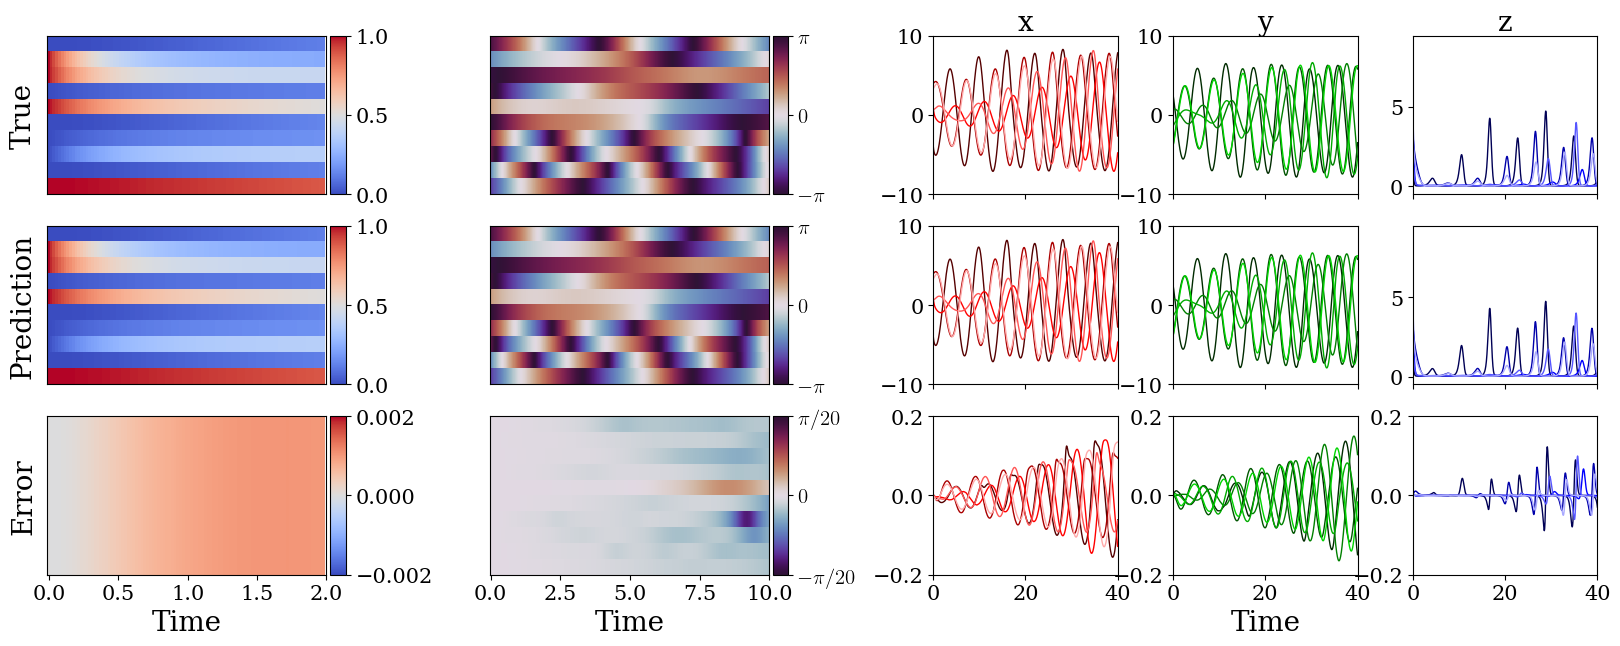

In [53]:
fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 2.0], wspace=0.25)

plot_heat(gs[0], 4)
plot_kuramoto(gs[1], 31)
plot_rossler(gs[2], 19)

fig.tight_layout(pad=0.0)
fig.show()